# Predicting house prices | Model comparison

### **Notebook objective:** To build a robust model that can accurately predict `SalePrice`
### **Primary model evaluation metric:** Root Mean Squared Error (RMSE / RMSLE) 

#### _For the Kaggle [house prices competition][2]_
#### _Based on the workbook from [Serigne][1]_ 

[1]: https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard
[2]: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

#### Notebook organization
- Loading libraries
- Reading train and test files
- Data processing
    - Outliers
    - Log-transformation of target variable `SalePrice`
    - Combining the training and test datasets
    - Feature engineering
    - Correlation heatmap
    - Missing data and imputation
    - Transforming numerical variables
    - Label encoding categorial variables
    - Creating an additional feature: Total Square Footage
    - Checking for skewed numerical features
    - Box Cox Transformation of skewed features
    - Aquiring dummy categorical variables
    - Creating new training and test datasets
- Modeling
    - K-fold validaton
    - Base models
        - Lasso regression
        - Elastic Net regression
        - Kernel Ridge regression
        - Gradient Boosting regression
        - XGBoost
        - LightGBM
        - Base model scores evaluated on rmsle
    - Stacking the base models
        - Averaging the models
        - Meta model
        - Model evaluation
    - Ensembling the stacked model with XGBoost and LightGBM
    - Prediction
- Submission



    
    

# Loading libraries and datasets


In [1]:

# Importing libraries
import pandas as pd # Pandas: Used for tubular data analysis
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import numpy as np # Numpy: Used for scientific computation
import matplotlib.pyplot as plt
from scipy import stats # Scipy: Algorithms for optimization, integration, interpolation, eigenvalue problems, algebraic equations
from scipy.stats import norm, skew
import statsmodels.stats.api as sms # Statsmodels: Used for time-series analysis
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC # Sklearn: Machine learning library
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Getting the working directory
#os.getcwd()
#os.chdir(path)

# To remove warnings from final output
#import warnings
#def ignore_warn(*args, **kwargs):
#    pass
#warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory
#files = [file for file in os.listdir('../input')] 

# Checking package versions (if necessary)
#np.__version__ # Numpy example

data_description.txt
sample_submission.csv
test.csv
train.csv



In [3]:
# Loading the training and testing datasets into a Pandas dataframe
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# Checking the numbers of samples and features
print("Full train dataset shape is: {}".format(train.shape))
print("Full test dataset shape is: {}".format(test.shape))

Full train dataset shape is: (1460, 81)
Full test dataset shape is: (1459, 80)


In [4]:
# Exploring the train dataset
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Exploring the test dataset
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
test.info()

In [6]:
# Saving the 'Id' column for reference
train_ID = train['Id']
test_ID = test['Id']

# Dropping the 'Id' column (unnecessary for  the prediction process)
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Checking the numbers of samples and features after dropping the 'Id' column
print("\nThe train data size after dropping Id feature is: {} ".format(train.shape)) 
print("The test data size after dropping Id feature is: {} ".format(test.shape))


The train data size after dropping Id feature is: (1460, 80) 
The test data size after dropping Id feature is: (1459, 79) 


# Data Processing

## Outliers

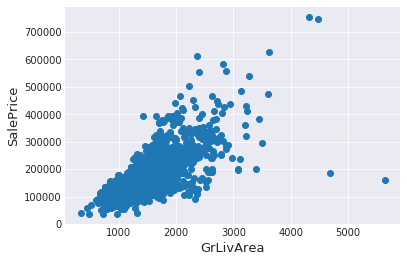

In [7]:
# Examining relationship between `GrLivArea` and `SalePrice` for potential outliers 
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

At the bottom right, there are two extremely large GrLivArea data points with a low price. These values can be classified as outliers and removed.

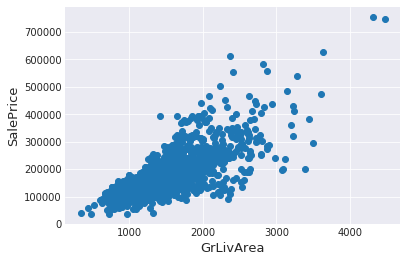

In [8]:
# Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Double checking the graphic relationship between `GrLivArea` and `SalePrice`
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

## Target Variable (`SalePrice`) exploration and transformation


 mu = 180932.92 and sigma = 79467.79



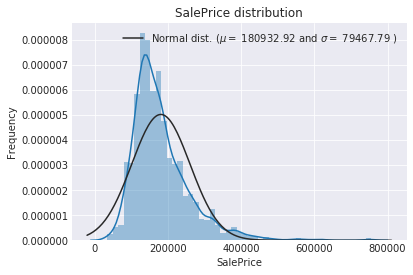

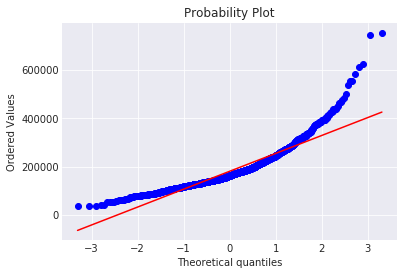

In [9]:
# Aquiring the fitted parameters: Population mean (mu) and standard deviation (sigma)
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# `SalePrice` distribution plot
sns.distplot(train['SalePrice'] , fit=norm);
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot of `SalePrice` (Probability plot)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The target variable `SalePrice` is skewed right. To make sure our data is normally distributed, we need to transform the `SalePrice` variable.

 ### Log-transformation of the target variable 


 mu = 12.02 and sigma = 0.40



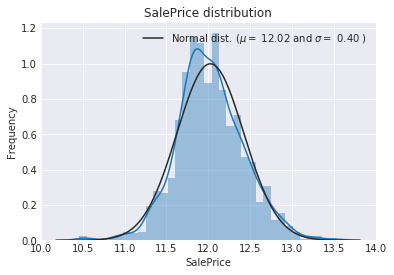

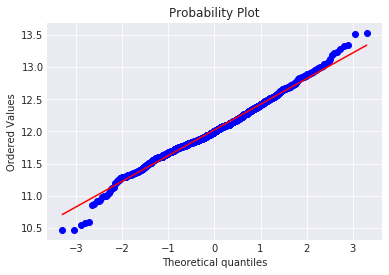

In [10]:
# Log-transformation of all elements of the `SalePrice` column
train["SalePrice"] = np.log1p(train["SalePrice"])

# Aquiring the new fitted parameters: Population mean (mu) and standard deviation (sigma)
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# New `SalePrice` distribution plot
sns.distplot(train['SalePrice'] , fit=norm);
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# New QQ-plot of `SalePrice` (Probability plot)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


## Feature engineering
Great resource for learning more about [feature engineering][2]

[2]: https://www.kaggle.com/code/ryanholbrook/what-is-feature-engineering

In [11]:
# Aggregating the train and test data into one dataset
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


### Correlation heatmap

A heatmap of correlations between numerical / quantitative features and the sale price to identify which variables are most related to the price. A heatmap of correlations between numerical / quantitative features and the sale price to identify which variables are most related to the price.

In [2]:
# Correlation map to visualize how features are correlated with `SalePrice`
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

NameError: name 'train' is not defined

### Missing Data

In [12]:
# Identifiying the percentage of null data points and dropping them
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


Text(0.5,1,'Percentage of missing data points by feature')

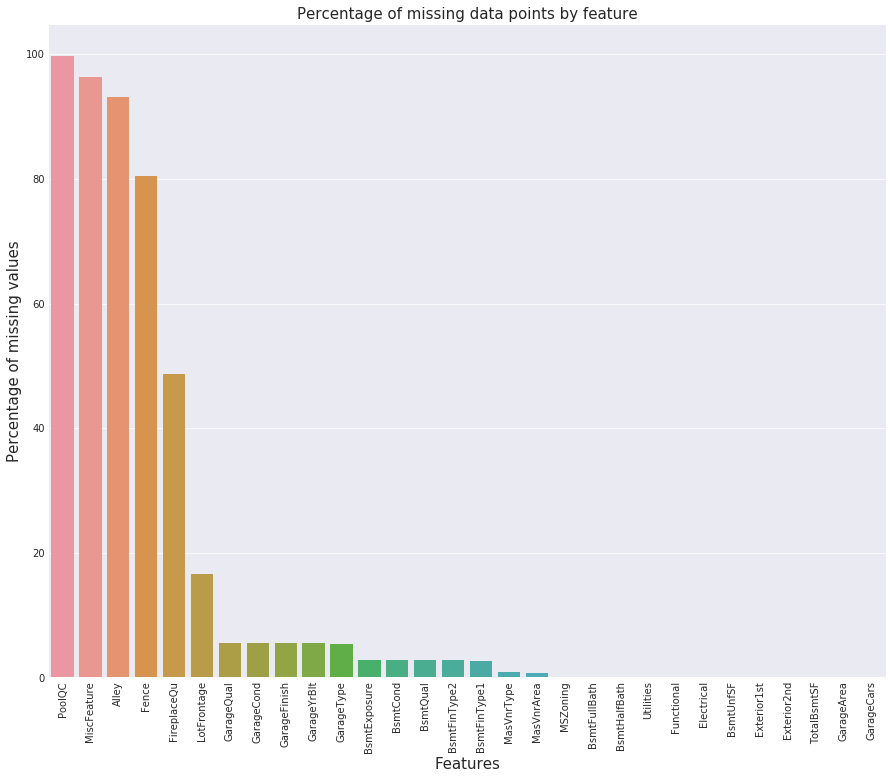

In [13]:
# Plotting the percentage of missing data points by feature
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percentage of missing values', fontsize=15)
plt.title('Percentage of missing data points by feature', fontsize=15)

### Imputing missing values

Imputation of NAs and missing values based on the data descriptions available

**PoolQC:** NA means "No  Pool" - This makes intuitive sense, especially given that the majority of houses have no Pool 

In [15]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

**MiscFeature:** NA means "no misc feature"


In [16]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

**Alley:** NA means "no alley access"

In [17]:
all_data["Alley"] = all_data["Alley"].fillna("None")

**Fence:** NA means "no fence"

In [18]:
all_data["Fence"] = all_data["Fence"].fillna("None")

**FireplaceQu:** NA means "no fireplace"

In [19]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

**LotFrontage:** As the `LotFrontage` area of each house in a neighborhood is likely to be similar, we can fill in missing values with the median `LotFrontage` of the neighborhood

In [20]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

**GarageType, GarageFinish, GarageQual and GarageCond:** Replacing missing values with 'None'

In [21]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

**GarageYrBlt, GarageArea and GarageCars:** Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [22]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

**BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath:** Replacing missing values with 0, as there is likely none if it is missing

In [23]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

**BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2:** For all these categorical basement-related features, NaN means that there is no basement


In [24]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

**MasVnrArea and MasVnrType:** NA most likely means no masonry veneer, we can fill in 0 for the area and None for the type


In [25]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

**MSZoning (The general zoning classification):** 'RL' is by far the most common value, so we can fill in missing values with 'RL'


In [26]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

**Utilities:** For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NAs. As the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. Therefore, we can safely remove it

In [27]:
all_data = all_data.drop(['Utilities'], axis=1)

**Functional:** NA means typical

In [28]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

**Electrical:** There is one NA value. Since this feature is mostly 'SBrkr', we can set that for the missing value


In [29]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

**KitchenQual:** There is one NA value, and same as Electrical, we set it to 'TA' (which is the most frequent) for the missing value in KitchenQual


In [30]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

**Exterior1st and Exterior2nd:** Both Exterior 1 & 2 only have one missing value, so we will substitute in the most common string


In [31]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

**SaleType:** Filled in with the most common string - "WD"

In [32]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

**MSSubClass:** NA most likely means no building class, so we can replace the missing values with None


In [33]:

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



In [34]:
# Double check that there are no remaining missing values
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### Transforming numerical variables that should be categorical

In [35]:
# `MSSubClass` = The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


# Changing `OverallCond` into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


# Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)



### Label Encoding categorical variables that may contain information in their ordering set

In [36]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# Shape of dataset 
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


### Creating an additional feature: Total Square Footage


In [37]:
# Creating a new feature that captures total square footage
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


### Checking for skewed numerical features

In [38]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


### Box Cox Transformation of skewed features
We use the scipy function boxcox1p which computes the Box-Cox transformation of 1+x. Note that setting λ=0 is equivalent to log1p used above for the target variable.

In [39]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


### Getting dummy categorical features

In [40]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


### Creating new train and test datasets

In [41]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modelling

### K-fold validaton

In [42]:
# K-fold validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Manual split (for reference)

In [43]:
# def split_dataset(all_data, test_ratio=0.30):
#  test_indices = np.random.rand(len(all_data)) < test_ratio
#  return all_data[~test_indices], all_data[test_indices]

# train_ds_pd, valid_ds_pd = split_dataset(df)
# print("{} examples in training, {} examples in testing.".format(
#    len(train_ds_pd), len(valid_ds_pd)))

## Base models

**LASSO  Regression:** 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler()  method on pipeline 

In [44]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

**Elastic Net Regression:**

Made robust to outliers

In [45]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

**Kernel Ridge Regression:**

In [46]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

**Gradient Boosting Regression:**

With **huber** loss it is more robust to outliers
    

In [47]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

**XGBoost:**

In [48]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)



**LightGBM:**

In [49]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Base model scores evaluated on rmsle

In [50]:
# Lasso Regression
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [51]:
# Elastic Net Regression
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [52]:
# Kernel Ridge Regression
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [53]:
# Gradient Boosting Regression
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1177 (0.0080)



In [54]:
# XGBoost
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1161 (0.0079)



In [55]:
# LightGBM
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` 

LGBM score: 0.1153 (0.0057)



## Stacking the base models

### Averaged base models

**Averaged base models class**

In [56]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # First define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Then train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # Then predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

In [57]:
# Average four models here: ENet, GBoost, KRR and lasso
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1091 (0.0075)



### Meta-model

**Stacking averaged Models Class**

In [58]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # Do the predictions of all base models on the test data and use the averaged predictions as meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Stacking averaged models score**

To make the two approaches comparable (by using the same number of models), average **Enet, KRR and Gboost**, then add **lasso as the meta-model**.

In [59]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1085 (0.0074)


## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the** StackedRegressor** defined previously

In [60]:
# Defining an rmsle evaluation function 
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


### Final Training and Prediction

**StackedRegressor:**

In [61]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.0781571937916


**XGBoost:**

In [62]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.0785165142425


**LightGBM:**

In [63]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


0.072050888492


In [64]:
# RMSE on the entire Train data when averaging

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.0752374213174


**Ensemble prediction:**

In [ ]:
ensemble = stacked_pred*0.65 + xgb_pred*0.15 + lgb_pred*0.20

**Submission**

In [66]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)